# Nombre: Salvador Gimeno - Seminario

#### Github: https://github.com/salvagimeno-ai/03MAIR-Algoritmos-de-optimizacion/tree/master/SEMINARIOS



Elección de grupos de población homogéneos
Descripción del problema:

Una productora ganadera nos encarga la tarea de seleccionar grupos de terneros para aplicar 3 tratamientos diferentes.

Para cada uno de los tratamientos debemos seleccionar 3 grupos de terneros que sean lo mas homogéneos posible en peso para que en los resultados del tratamiento influya lo menos posible el peso del animal.

Disponemos de una población de N animales entre machos y hembras.

Hemos podido averiguar que el peso medio del ternero es 35kg con una desviación estándar de 3.1.

Se solicita diseñar un algoritmo para conseguir una agrupación que cumpla de la mejor manera posible las especificaciones de la productora.

(*) La respuesta es obligatoria

In [0]:
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import random
import pprint
import sys
import pandas as pd
sys.setrecursionlimit(100000)
import math

## Definimos_parametros

In [0]:
# definimos_parametros:
  mu = 35      # media
  sigma = 3.1  # standard deviation
  N = 200
  T = 3        # numero de Tratamientos
  G = 3        # numero de grupos por tratamiento 
  S = 3        # tamaño de los grupos
  IT_MAX = 5   # numero de iteraciones maximo
  IT_ACT = 1   # iteracion actual (inicializada a valor 1)
  Hubo_Reasignacion_Clusters = ''    # variable para identificar si hubo reasignacion de clusters
  Clusters_reasignados = 10e10

In [0]:
# FUNCION PARA Calculo Distancia a los Centroides (distancia euclídea):
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

## Generamos_universo

Distribucion de pesos: 


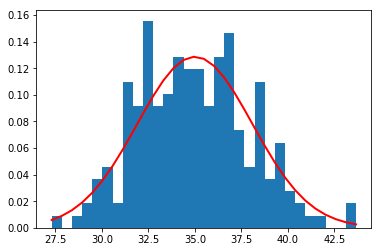

C1:  30.09834869140663
C2:  32.20954644578777
C3:  40.23234961941446


In [4]:
def generamos_universo(mu, sigma, N):
# generamos pesos de forma aleatoria con distribucion normal
  W = np.random.normal(mu, sigma, N)
  #print('matriz de pesos W : ', W)

  # Elegimos de forma aleatoria los centroides de los clusters iniciales 
  CENTROIDES = np.random.choice(W,3)
  C1=CENTROIDES[0] ; #print('C1: ',C1)
  C2=CENTROIDES[1] ; #print('C2: ',C2)
  C3=CENTROIDES[2] ; #print('C3: ',C3)

  # Adicionamos los centroides iniciales a la matriz de Centroides (CEN_df)
  CEN_df = []
  CEN = [(0,0,C1,C2,C3)]
  CEN_df = pd.DataFrame(CEN,columns=['Ejecucion','Nivel', 'C1', 'C2', 'C3' ]) 
  
  # dibujar histograma con la funcion de densidad de probabilidad 
  import matplotlib.pyplot as plt
  count, bins, ignored = plt.hist(W, 30, density=True)
  plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
  print("Distribucion de pesos: ")
  plt.show()
  
  #Generacion randomica de sexos
  Sex = np.random.randint(0,2,N)     # 0 = Male, 1 = Female
  
  # Juntamos e Indexamos los datos del array de pesos y de sexo
  UNIVERSO = []
  UNIVERSO = [(i, Sex[i], W[i], 0, 0, 0 ) for i in range(N)]
  #print(UNIVERSO)

  # CONVERTIMOS EL DICCIONARIO A DATAFRAME
  UNIVERSO_df = pd.DataFrame(UNIVERSO,columns=['Indice', 'Sexo', 'Peso','Distancia', 'Grupo', 'Tratamiento' ]) 

  return UNIVERSO_df, C1, C2, C3, CEN_df

UNIVERSO_df, C1, C2, C3, CEN_df = generamos_universo(mu, sigma, N)
print('C1: ',C1); print('C2: ',C2); print('C3: ',C3); #print('CEN_df: ',CEN_df);

In [5]:
UNIVERSO_df.sample(10)

,Indice,Sexo,Peso,Distancia,Grupo,Tratamiento
100,100,1,34.932819,0,0,0
12,12,1,32.721683,0,0,0
6,6,0,41.084683,0,0,0
14,14,0,35.963867,0,0,0
149,149,1,40.661470,0,0,0
107,107,0,35.715244,0,0,0
79,79,1,28.584959,0,0,0
87,87,0,33.424263,0,0,0
156,156,1,32.867643,0,0,0
26,26,1,32.110504,0,0,0


## CONTEXTO DEL PROBLEMA

**El problema exige**: a partir de una poblacion de N animales, generar 3 grupos de animales que sean homogeneos en cuanto a peso, para cada uno de los 3 tratamientos diferentes que se van a experimentar. Se deberá “Homogeneizar” dentro de los grupos y entre grupos.

**Por tanto tendremos que generar**:
- Primero: 3 grupos dentro del Universo que sean lo mas homogéneos dentro de si mismos y heterogéneos entre sí - uno para cada tratamiento.
- Segundo: Dentro del cluster de cada tratamiento, generaremos 3 grupos que sean homogéneos entre sí.

## COMO LO VAMOS A RESOLVER:

La **clusterizacion** es una técnica comunmente usada para clasificar objetos formando grupos/conglomerados (clúster) que sean lo más homogéneos posible dentro de si mismos y heterogéneos entre sí.
Este agrupamiento se basa en la idea de distancia o similitud entre las observaciones y la obtención de dichos clusters depende del criterio o distancia considerados.

En este problema la clusterizacion:
- una única variable para la definicion de grupos homogéneos: el peso
- definiremos 3 clusters - uno para cada tratamiento 
- nos falta definir la medida de proximidad o de distancia los animales, para poder cuantificar el grado de similaridad entre ellos.

#### METODOS DE CLASIFICACION:
Se distinguen dos grandes categorías de métodos clusters: Métodos jerárquicos y Métodos no-jerárquicos

*   Métodos Jerárquicos: En cada paso del algoritmo sólo un objeto cambia de grupo y los grupos están anidados en los de pasos anteriores. Si un objeto ha sido asignado a un grupo ya no cambia más de grupo.  La clasificación resultante tiene un número creciente de clases anidadas.

*   Métodos No jerárquico o Repartición: Comienzan con una solución inicial, un número de grupos g fijado de antemano y agrupa los objetos para obtener los g grupos.

#### PROCESO TÍPICO PARA LA DEFINICION DE GRUPOS HOMOGENEOS
*   **Paso 1: Selección de variables** - en este caso está pre-determinado que la variable de clusterizacion será el PESO.
*   **Paso 2: Detección de valores atípicos**. El análisis clúster es muy sensible a la presencia de objetos muy diferentes del resto (valores atípicos) - como estamos en una distribucion normal podria ser eliminadas las colas de la distribución, y trabajar solamente con la parte central: delimitando -Desv.Estandar / +Desv.Estandar desde la media, lo cual representará al 68,27% de los datos.
*   **Paso 3. Seleccionar la forma de medir la distancia/disimilitud entre objetos** dependiendo de si los datos con cuantitativos o cualitativos
*   **Paso 4: Estandarización de los datos** (Decidir si se trabaja con los datos según se miden o estandarizados). El orden de las similitudes puede cambiar bastante con sólo un cambio de escala de una de las variables por lo que sólo se realizará una tipificación cuando resulte necesario.
*   Paso 5: Obtención de los clusters y valoración de la clasificación realizada

bibliografia utilizada: http://wpd.ugr.es/~bioestad/guia-spss/practica-8/ 




### METODO DE CLUSTERIZACION SELECCIONADO PARA EL EJERCICIO:
**Análisis clúster de k-medias**. Es un método de clasificación No Jerárquico (Repartición). El número de clusters que se van a formar es fijado de antemano (requiere conocer el número de clusters a priori) y se agrupan los objetos para obtener esos grupos. Comienzan con una solución inicial y los objetos se reagrupan de acuerdo con algún criterio de optimalidad. El clúster no jerárquico sólo puede ser aplicado a variables cuantitativas. Este procedimiento  puede analizar archivos de datos grandes.

*   Paso 1. Se toman al azar k clusters iniciales y se calculan los centroides (medias) de los clusters
*   Paso 2. Se calcula la distancia euclídea de cada observación a los centroides de los clusters y se reasigna cada observación al grupo más próximo formando los nuevos clusters que se toman en lugar de los primeros como una mejor aproximación de los mismos
*   Paso 3. Se calculan los centroides de los nuevos clusters
*   Paso 4. Se repiten los pasos 2) y 3) hasta que se satisfaga un criterio de parada como, por ejemplo, no se produzca ninguna reasignación, es decir, los clusters obtenidos en dos iteraciones consecutivas son los mismos.

Bibliografia utilizada: http://wpd.ugr.es/~bioestad/guia-spss/practica-8/ 


### MEDIDA DE HOMOGENEIDAD SELECCIONADA:
Usaremos la distancia euclídea de cada observación a los centroides de los clusters


# PREGUNTAS DEL EJERCICIO:

## Pregunta: ¿Cuantas posibilidades hay sin tener en cuenta las restricciones?

Numero de combinaciones: Variaciones sin repetición de N elementos de n en n

Fórmula : V N,n = N.(N-1).(N-2)...(N-n+1)
Tenemos que generar 3 grupos x 3 tratamientos = 9 grupos x 2 sexos

Dado que las combinaciones de cada sexo son independientes entre si, el calculo total de combinaciones será igual al numero de combinaciones de los machos + numero combinaciones de las hembras.

Siendo, N = total de terneros M = total de machos H = total de hembras

se cumple que N = M + H

En este caso, el numero total de variaciones, siendo n = 9, sería:

V = (M.(M-1).(M-2)...(M-10)) + (H.(H-1).(H-2)...(H-10))

#### ¿Cuantas posibilidades hay teniendo en cuenta todas las restricciones.¶

Las unicas restricciones mencionadas en el enunciado del problema son que el peso medio del ternero es 35kg con una desviación estándar de 3.1

NO entiendo como esto podria afectar al numero de combinaciones posibles.

## 1) Pregunta: (*) ¿Cual es la estructura de datos que mejor se adapta al problema? Argumenta la respuesta

Datos de Entrada/ datos generados:
    -ID/Sexo/Peso

Datos de Salida:
    - Indice	Sexo	Peso	Distancia	Grupo	Tratamiento
    


## 2) Pregunta: ¿Cual es la función objetivo?

In [0]:
Minimizar la Dispersion IntraCluster

## 3) Pregunta: ¿Es un problema de maximización o minimización?


Maximizar la Homogeneidad en cada Tratamiento, y maximizar la homogeneidad entre los grupos de dicho tratamiento.

Podriamos hablar de Minimizar la Dispersion IntraCluster al mismo tiempo que Maximizamos la Dispersion InterClusters.

## 4) Pregunta: Diseña un algoritmo para resolver el problema por fuerza bruta

1) Hariamos una iteracion por todas las permutaciones de los valores del universo agrupadas de 3 en 3, y eligiriamos aquella combinacion donde se cumpliese que: max(homogeneidad en los 3 grupos en si mismos) 

2) Para cada uno de eses grupos (equivalentes a cada tratamiento) haremos una iteracion por todas las permutaciones de los valores de ese grupo (tratamiento) agrupadas de 3 en 3, y eligiriamos aquella combinacion donde se cumpliese que: max(homogeneidad en los 3 grupos en si mismos)


## 5) Pregunta: Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta

Paso 1. Se toman al azar k clusters iniciales y se calculan los centroides (medias) de los clusters

Paso 2. Se calcula la distancia euclídea de cada observación a los centroides de los clusters y se reasigna cada observación al grupo más próximo formando los nuevos clusters que se toman en lugar de los primeros como una mejor aproximación de los mismos

Paso 3. Se calculan los centroides de los nuevos clusters

Paso 4. Se repiten los pasos 2) y 3) hasta que se satisfaga un criterio de parada como, por ejemplo, no se produzca ninguna reasignación, es decir, los clusters obtenidos en dos iteraciones consecutivas son los mismos

### DEFINIR 3 CLUSTERS - 1 x TRATAMIENTO

In [6]:
# ASIGNACION DE CLUSTERS
Clusters_reasignados = ''
numero_iteraciones = 0
while Clusters_reasignados != 0:
  Clusters_reasignados = 0
  
  while numero_iteraciones <= IT_MAX:  # iteramos hasta un maximo de iteraciones definido en los parametros globales 'IT_MAX'

    # CALC.DISTANCIA EUCLIDEA y ASIGNACION DE CLUSTER
    for i in UNIVERSO_df.itertuples():
      Hubo_Reasignacion_Clusters = ''

      # calculamos la distancia euclidea con cada centroide
      A = euclidean_distance(i.Peso,C1)   #; print('A = ', A)
      B = euclidean_distance(i.Peso,C2)   #; print('B = ', B)
      C = euclidean_distance(i.Peso,C3)   #; print('C = ', C)

      # determinamos el cluster_mas_cercano a partir de la menor distancia
      cluster = ''
      if(A < B and A < C):
        distancia = A
        cluster = 0
      else:
        if(B < A and B < C):
          distancia = B
          cluster = 1
        else:
          distancia = C
          cluster = 2

      if i.Grupo != cluster:
        Clusters_reasignados += 1
        #print('indice: ', i.Indice) 
        #print('Grupo: ', i.Grupo) 
        #print('Cluster: ', cluster)
        #Hubo_Reasignacion_Clusters = 'True'
        #print(Hubo_Reasignacion_Clusters)
        #print('-----------')

      # Actualizamos el df de salida (UNIVERSO_df)
      #UNIVERSO.at[i.Index, 'Indice'] = i
      #UNIVERSO.at[i.Index, 'Peso'] = i.Peso
      UNIVERSO_df.at[i.Index, 'Distancia'] = distancia
      UNIVERSO_df.at[i.Index, 'Grupo'] = cluster
      UNIVERSO_df.at[i.Index, 'Tratamiento'] = cluster

    # Recalculamos los centroides de los nuevos clusters generados
    result_clusters = UNIVERSO_df.groupby('Grupo').mean()
    C1 = result_clusters['Peso'][0]
    C2 = result_clusters['Peso'][1]
    C3 = result_clusters['Peso'][2]

    numero_iteraciones += 1

  
  #return UNIVERSO_df, Clusters_reasignados

print('UNIVERSO_df ',UNIVERSO_df) 
print('Clusters_reasignados ', Clusters_reasignados) 
print('numero_iteraciones ', numero_iteraciones) 

UNIVERSO_df       Indice  Sexo       Peso  Distancia  Grupo  Tratamiento
0         0     1  37.061239          1      2            2
1         1     1  32.692956          1      0            0
2         2     0  29.879568          1      0            0
3         3     1  36.089138          1      1            1
4         4     1  33.849535          0      1            1
5         5     1  37.268650          0      2            2
6         6     0  41.084683          2      2            2
7         7     0  38.274888          0      2            2
8         8     0  34.733522          0      1            1
9         9     1  38.375238          0      2            2
10       10     1  35.484899          1      1            1
11       11     1  35.903342          1      1            1
12       12     1  32.721683          1      0            0
13       13     0  43.353185          5      2            2
14       14     0  35.963867          1      1            1
15       15     1  37.89004

## NOTAS: POR FALTA DE TIEMPO NO HE CONSEGUIDO TERMINAR ALGUNAS COSAS;
## FALTARIA:

1) Haber discriminado en el código para poder hacer una ejecucion para Machos y Hembras por separado

2) Crear grupos homogeneos entre la poblacion de cada tratamiento


